In [1]:
from google.colab import auth
import pandas as pd
import gspread
from oauth2client.client import GoogleCredentials

from keras import layers
import numpy as np
from keras.models import Model
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding

In [2]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
"We took our dataset from: SPLASH: in vivo mapping of eukaryotic RNA interactomes"
worksheet = gc.open('shuffled_final_splash_df').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame(rows)
df.columns = df.iloc[0]
df = df.iloc[1:]

In [3]:
def EncodeSequences(dataframe):
    """
    Using Squares of Pure numbers as codes for each nucleotide(Other Encoding 
    methods such as one hot encoding, and encoding based on number of hydrogen bonds of each nucleotide
    have been tested but integer encoding reached higher accuracy.)
    :param dataframe: contains [two RNA sequences] + [one-hot label (whether two sequences have interaction or not)]
    :return: Two encoded RNA sequences 
    """
    seq1_ = list(dataframe['seq1'])
    seq2_ = list(dataframe['seq2'])
    seq1s = []
    seq2s = []
    for s in seq1_:
      # =========== Encode Sequence 1  ==========
      seq1 = [529 if x == 'A' else x for x in s]
      seq1 = [361 if x == 'U' else x for x in seq1]
      seq1 = [121 if x == 'C' else x for x in seq1]
      seq1 = [169 if x == 'G' else x for x in seq1]
      seq1 = [0 if x == 'N' else x for x in seq1]

      seq1s.append(seq1)
    for s in seq2_:
      # ============ Encode Sequence 2 ==========
      seq2 = [529 if x == 'A' else x for x in s]
      seq2 = [361 if x == 'U' else x for x in seq2]
      seq2 = [121 if x == 'C' else x for x in seq2]
      seq2 = [169 if x == 'G' else x for x in seq2]
      seq2 = [0 if x == 'N' else x for x in seq2]
      seq2s.append(seq2)

    seq1s = np.array(seq1s)
    seq2s = np.array(seq2s)

    return seq1s, seq2s

In [10]:
def model(trainSeq1, trainSeq2, trainLabel, testSeq1, testSeq2, testLabel):
    """
    Multi-input model which learn features of the RNA transcripts separately, 
    then concatenate feature vectors of RNA sequences and fed the new feature 
    vector to three fully connected layers.
    :param trainSeq1, trainSeq2, trainLabel, testSeq1, testSeq2, testLabel
    :return: 

    """

    input_1 = layers.Input(
        shape=( np.shape(trainSeq1)[1]))

    emb1 = layers.Embedding(530 , 10, input_length = np.shape(trainSeq1)[1])(input_1)         
    emb1 = layers.Reshape((np.shape(trainSeq1)[1], 10))(emb1)

    cnn1 = layers.Conv1D(128, kernel_size=3, activation = 'relu')(emb1)
    cnn1 = layers.Conv1D(64, kernel_size=3, activation = 'relu')(cnn1)
    cnn1 = layers.MaxPooling1D(pool_size=2)(cnn1)
    cnn1 = layers.Conv1D(32, kernel_size=3, activation = 'relu')(cnn1)
    cnn1 = layers.MaxPooling1D(pool_size=2)(cnn1)
    cnn1 = layers.Conv1D(32, kernel_size=3, activation = 'relu')(cnn1)
    cnn1 = layers.MaxPooling1D(pool_size=2)(cnn1)

    cnn1 = layers.Flatten()(cnn1)


    input_2 = layers.Input(
        shape=( np.shape(trainSeq1)[1]))
    
    emb2 = Embedding(530 , 10, input_length = np.shape(trainSeq1)[1])(input_2)
    emb2 = layers.Reshape((np.shape(trainSeq1)[1], 10))(emb2)

    cnn2 = layers.Conv1D(filters=128, kernel_size=3, activation = 'relu')(emb2)
    cnn2 = layers.Conv1D(filters=64, kernel_size=3, activation = 'relu')(cnn2)
    cnn2 = layers.MaxPooling1D(pool_size=2)(cnn2)
    cnn2 = layers.Conv1D(filters=32, kernel_size=3, activation = 'relu')(cnn2)
    cnn2 = layers.MaxPooling1D(pool_size=2)(cnn2)
    cnn2 = layers.Conv1D(filters=32, kernel_size=3, activation = 'relu')(cnn2)
    cnn2 = layers.MaxPooling1D(pool_size=2)(cnn2)
    cnn2 = layers.Flatten()(cnn2)


    merged_vector = layers.Add()([cnn1, cnn2])

    fc = layers.Dense(128, activation='sigmoid')(merged_vector)
    fc = layers.Dense(32, activation='relu')(fc)
 
    out_put = layers.Dense(2, activation='softmax')(fc)             


    model = Model(inputs = [input_1, input_2], outputs = out_put)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit([trainSeq1, trainSeq2], trainLabel, validation_data = ([testSeq1, testSeq2], testLabel), batch_size= 64, epochs=20, verbose=1)
    model.summary()
    score = model.evaluate([testSeq1, testSeq2], testLabel, verbose=1)

    return score[1], history

Epoch 1/20
11/11 [==============================] - 3s 180ms/step - loss: 0.7047 - accuracy: 0.4937 - val_loss: 0.6895 - val_accuracy: 0.5641
Epoch 2/20
11/11 [==============================] - 2s 155ms/step - loss: 0.6965 - accuracy: 0.5268 - val_loss: 0.6935 - val_accuracy: 0.4359
Epoch 3/20
11/11 [==============================] - 2s 150ms/step - loss: 0.6987 - accuracy: 0.5147 - val_loss: 0.7003 - val_accuracy: 0.4359
Epoch 4/20
11/11 [==============================] - 2s 154ms/step - loss: 0.6927 - accuracy: 0.5066 - val_loss: 0.6898 - val_accuracy: 0.5641
Epoch 5/20
11/11 [==============================] - 2s 155ms/step - loss: 0.6939 - accuracy: 0.4873 - val_loss: 0.6989 - val_accuracy: 0.4359
Epoch 6/20
11/11 [==============================] - 2s 157ms/step - loss: 0.6944 - accuracy: 0.4917 - val_loss: 0.6940 - val_accuracy: 0.4359
Epoch 7/20
11/11 [==============================] - 2s 155ms/step - loss: 0.6911 - accuracy: 0.5059 - val_loss: 0.6844 - val_accuracy: 0.6538
Epoch 

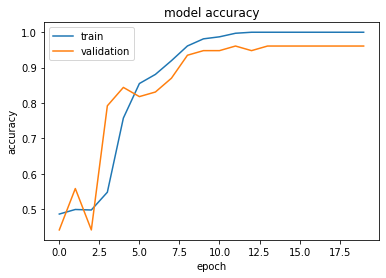

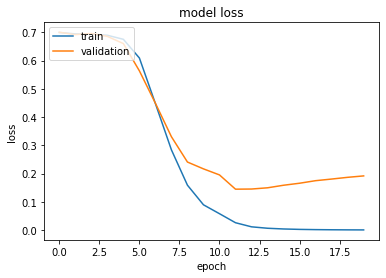

0.954878443479538


In [12]:
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
"10 Fold Cross Validation"
kfold = KFold(10, True, 1)
acc = 0
cnt = 0
for train, test in kfold.split(df):
  train_df = df.iloc[train, :]
  test_df = df.iloc[test, :]

  seq1_train, seq2_train = EncodeSequences(train_df)
  seq1_test, seq2_test = EncodeSequences(test_df)

  label_train = np.array(train_df[['tag1', 'tag2']].values.astype(int).tolist())
  label_test = np.array(test_df[['tag1', 'tag2']].values.astype(int).tolist())
  score, history = model(seq1_train, seq2_train, label_train, seq1_test, seq2_test, label_test)
  acc += score
  cnt += 1
  if (cnt == 10):
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

acc /= 10
print(acc)